## 設定參數

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
CRYPTO_TARGET = 'TINYAES128C'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

## 抓板子

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


## 編AES-128的程式

In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CW308_STM32F4 with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
    simpleserial-aes.c ...Done!
.
Compiling:
    .././simpleserial/simpleserial.c ...Done!
.
Compiling:


In file included from .././hal/stm32f4/stm32f4_hal.c:3:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


    .././hal/stm32f4/stm32f4_hal.c ...Done!
.
Compiling:


In file included from .././hal/stm32f4/stm32f4_hal_lowlevel.c:39:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition


    .././hal/stm32f4/stm32f4_hal_lowlevel.c ...Done!
.
Compiling:
    .././hal/stm32f4/stm32f4_sysmem.c ...Done!
.
Compiling:
    .././hal/stm32f4/stm32f4xx_hal_rng.c ...Done!
.
Compiling:
    .././crypto/tiny-AES128-C/aes.c ...Done!
.
Compiling:
    .././crypto/aes-independant.c ...Done!
.
Assembling: .././hal/stm32f4/stm32f4_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CW308_STM32F4/stm32f4_startup.lst -I.././simpleserial/ -I.././simpleserial/ -I.././hal -I.././hal/stm32f4 -I.././hal/stm32f4/CMSIS -I.././hal/stm32f4/CMSIS/core -I.././hal/stm32f4/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto/ -I.././crypto/tiny-AES128-C .././hal/stm32f4/stm32f4_startup.S -o objdir-CW308_STM32F4/stm32f4_startup.o
.
LINKING:
    simpleserial-aes-CW308_STM32F4.elf ...Done!
.
Creating load file for Flash: simpleserial-aes-CW308_STM32F4.hex
arm-none-eabi-objcopy -O i

## 將AES燒到板子上

In [4]:
fw_path = '../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex'.format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6587 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6587 bytes


###### 錄執行時AES(固定金鑰)的Trace、印出隨機產生的明文

In [5]:
#Capture Traces
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
scope.adc.samples = 24400

traces = []
trace_num = 2000  # Number of traces

proj_name = f"traces/{PLATFORM}_{CRYPTO_TARGET}_{trace_num}_fixedkey.cwp"    # 專案檔檔名，可以知道板子 加密算法 trace數 固定金鑰
project = cw.create_project(proj_name, overwrite=True)

for i in trange(trace_num, desc='Capturing traces'):
    key, text = ktp.next()  # manual creation of a key, text pair can be substituted here
    print(i, text)
    trace = cw.capture_trace(scope, target, text, key)                   # 抓trace
    
    if trace is None:
        continue
    project.traces.append(trace)                                         # 加到trace物件內
    
print(f'Number of samples = {scope.adc.samples}')
project.save()

Capturing traces:   0%|          | 0/2000 [00:00<?, ?it/s]

0 CWbytearray(b'f0 c3 3e 2e 96 aa 33 aa d2 fc 6f 22 d2 0e 93 cb')
1 CWbytearray(b'70 3a ee 44 45 43 0c 98 37 a5 67 74 f8 06 bd dd')
2 CWbytearray(b'f6 0c 03 ce f5 d4 14 28 8e 00 08 68 76 17 27 1c')
3 CWbytearray(b'c2 3c fc eb a3 f9 60 f6 c0 2b fb 00 23 42 34 c1')
4 CWbytearray(b'37 cf fd 5f 29 b8 0d 0a 6d 42 f7 8a 14 50 09 44')
5 CWbytearray(b'8b e2 de 65 97 a5 7f 30 dd 5b 3f 24 07 f6 1f 2f')
6 CWbytearray(b'7b c6 fc 89 1d a2 2d c2 ae 0f 51 03 00 f5 d5 8e')
7 CWbytearray(b'5e cc d3 04 6c 8c c3 d9 2d 9a ef 7d df 77 31 fa')
8 CWbytearray(b'6d 89 20 fc 43 c9 d2 28 60 b9 fe a1 89 d7 e0 11')
9 CWbytearray(b'a8 40 95 72 72 a2 37 2b 27 a9 65 51 b6 83 e8 14')
10 CWbytearray(b'e2 84 ba fa 21 b1 f9 2e 2f a9 37 10 56 c8 36 9f')
11 CWbytearray(b'c6 eb f5 b3 66 40 ad 53 f3 8c 1c 26 e4 d6 7d dc')
12 CWbytearray(b'3d 5f 58 da d6 2e 1d 00 a4 c6 27 4b 77 90 1a 79')
13 CWbytearray(b'fe 25 fb a6 62 ce 90 ae b6 ad 96 f6 5b 62 d6 3f')
14 CWbytearray(b'f5 ae f3 54 47 3e 93 ac 2a 90 f4 b3 37 cf 51 94')
15 CW

126 CWbytearray(b'1e ac 7b 3f bf e6 c7 57 a4 bc a4 4e 96 5b 70 f6')
127 CWbytearray(b'6b 7a a1 11 d9 40 9e f7 f7 1d 32 c8 ca 14 17 8f')
128 CWbytearray(b'c6 50 ee 9b 7d 4b da 70 e2 88 be bb 2e 17 00 7d')
129 CWbytearray(b'5d 32 34 3d f7 58 eb c1 33 ed 4a 72 9b cd cb c8')
130 CWbytearray(b'35 59 fa 5b bf 9f ef 29 9a 7d f2 19 5e f2 df 9a')
131 CWbytearray(b'93 a7 4a ef 18 d7 27 62 bb a1 3b 16 4a 66 98 0e')
132 CWbytearray(b'78 3a 5c 03 55 0e 66 3a ad 9c be fc d8 46 a9 72')
133 CWbytearray(b'd7 e3 63 2f 84 e8 33 55 56 4b 52 1d 4e ba 8c 82')
134 CWbytearray(b'14 f2 0f 36 ee 78 87 d5 6c 80 4f d2 78 46 5c 41')
135 CWbytearray(b'eb 71 52 f2 2c 23 99 c3 d7 41 97 23 20 1a 69 fb')
136 CWbytearray(b'0d 58 98 2a 2e ae 7d 22 59 c8 6f 25 95 1e cc a0')
137 CWbytearray(b'61 e2 c5 a4 12 20 40 cd 6c 24 5f 3c fa cf 6e 1b')
138 CWbytearray(b'88 c1 72 ac e1 4e a4 ae c6 71 6d 60 4e 75 c9 29')
139 CWbytearray(b'17 ec 1e 78 7a 1b a8 fd ef a9 32 8b 13 88 80 47')
140 CWbytearray(b'e4 26 4b 7b 36 81 80 13 08 61 

251 CWbytearray(b'b3 ca d8 63 ee d7 b9 9f c9 98 31 d3 6f 0c 3b ea')
252 CWbytearray(b'44 19 72 18 f1 8a fa 25 bc 7f 3d 08 5b 05 92 82')
253 CWbytearray(b'9b fc 77 80 9b 55 58 e0 1a bd f5 b5 6d c5 11 ad')
254 CWbytearray(b'c6 bb 03 76 d9 48 2c 26 3b 29 0a 66 dd 65 ec a8')
255 CWbytearray(b'36 0e 65 ef 8e 69 1b e8 48 55 2f c6 52 16 89 50')
256 CWbytearray(b'f8 14 f0 a0 5d 27 88 6a 6c c8 25 c2 02 72 a4 bd')
257 CWbytearray(b'f3 27 c4 16 88 08 1d 2f c6 e8 d0 da 13 63 57 85')
258 CWbytearray(b'cc 66 e4 20 87 37 22 dc 79 c7 c8 b5 fd f0 fc 70')
259 CWbytearray(b'38 99 51 72 6c 2c ce ef 83 60 5a f7 c4 a3 3b 53')
260 CWbytearray(b'4d 4d ac 01 66 6f 4f ef 5c f0 ef 5f 6a af 55 53')
261 CWbytearray(b'b4 eb 09 ba dd 6b 4a b0 e4 13 b8 84 38 e2 19 93')
262 CWbytearray(b'e0 ed 8e 36 2a 24 4e b2 b4 65 3a 81 18 73 3f 3f')
263 CWbytearray(b'3f c9 e8 6d a9 53 59 66 41 c5 83 ba 26 99 cf 17')
264 CWbytearray(b'28 f5 87 16 7f 95 c9 f3 c4 c2 13 bf 36 b3 8a 1b')
265 CWbytearray(b'2a 26 43 d9 b2 3f 8a 1b 9b fb 

373 CWbytearray(b'3f 04 14 57 76 43 6c 3b a6 15 ac 52 48 cb f7 a2')
374 CWbytearray(b'6e f7 73 42 6d 1f 44 80 bd 94 bb 84 64 ae 35 c0')
375 CWbytearray(b'2a 9f a6 59 0c 26 a7 5b 69 fd 45 7c d2 b3 07 8d')
376 CWbytearray(b'b2 87 6b a3 50 8f e2 07 6d a9 77 ec 37 b5 d1 9b')
377 CWbytearray(b'e8 14 1c c2 51 5d c3 16 29 42 27 cf b5 8f 78 2c')
378 CWbytearray(b'29 a9 13 e5 2a 1a 10 c3 da 47 e5 8a 22 bc 93 a8')
379 CWbytearray(b'58 4a aa 89 3a 91 ce 7a 6d a4 1d ed 23 2c fd 35')
380 CWbytearray(b'be 72 0e e0 87 c1 e8 a6 77 8a 6e d7 74 47 31 a7')
381 CWbytearray(b'4b 36 aa 95 60 53 8f 14 75 22 c2 6e 80 3e 5a 5d')
382 CWbytearray(b'd7 08 80 5e 11 4e 1f 95 07 1f 2a a1 0e 44 ec 3e')
383 CWbytearray(b'47 1d e7 43 d3 87 56 ab 91 5d ff 07 8e 23 fc 90')
384 CWbytearray(b'70 f4 b7 61 94 fe df 66 77 b7 0f e2 87 ce a1 b0')
385 CWbytearray(b'e9 4f 4d db e6 f4 9b 87 9d 65 e5 00 97 7c 17 c0')
386 CWbytearray(b'd8 66 2f aa 92 4a 55 78 08 be 43 52 7a fe 4b 99')
387 CWbytearray(b'2e 89 72 38 a2 89 0f 43 e7 d0 

495 CWbytearray(b'e2 6a 9e a4 94 cd 22 af ac e5 c3 09 c1 19 49 12')
496 CWbytearray(b'de f3 5e fc 71 ff 0a 98 78 58 53 88 9c 63 e5 fe')
497 CWbytearray(b'59 7f 84 89 a5 46 2a 26 e7 bc de 4b 64 52 f1 9c')
498 CWbytearray(b'c1 79 f1 e4 12 cc fd 93 50 9c 67 1b 8c 1d 30 63')
499 CWbytearray(b'56 6b 1e 5e bf 2a 74 79 ee 3f a1 1d ea b4 51 7d')
500 CWbytearray(b'32 28 cb c0 15 6a 6d 34 3c 4c 96 4e 0c 3c 74 20')
501 CWbytearray(b'ad 13 41 59 4b 17 17 36 c9 67 bc c4 6f ec 88 a1')
502 CWbytearray(b'd9 cb 68 69 45 4c c8 ec d5 27 3d 15 71 9c fc 53')
503 CWbytearray(b'33 88 01 3c 7e 60 cf 3f d1 60 10 a6 5f 8c 50 50')
504 CWbytearray(b'90 ae 7d 50 31 6e e4 60 55 40 96 61 ec a9 db 9c')
505 CWbytearray(b'15 f0 16 c3 12 91 2c 85 f0 94 b6 d3 40 ab 71 ce')
506 CWbytearray(b'2b 40 7d 73 00 58 00 f1 96 f1 2f 66 5a bc a0 2a')
507 CWbytearray(b'ef e2 09 7e 24 80 85 c3 b5 20 9d a6 98 a7 29 25')
508 CWbytearray(b'5d b0 4d c7 c2 b2 4a 0a c3 9b 05 09 f2 a8 e1 f0')
509 CWbytearray(b'1c 6e 22 d3 39 b2 71 96 25 89 

619 CWbytearray(b'21 8e fb 95 ea 66 fd 78 ed 0e a3 8c 6c 08 b7 45')
620 CWbytearray(b'db 01 11 64 5e 96 81 40 82 50 1f ba 69 50 c0 f3')
621 CWbytearray(b'27 89 da 75 3c 49 25 97 20 55 17 0e e0 2c ed fa')
622 CWbytearray(b'51 cb e4 f0 61 8d 5d da 3b cc 31 ba 68 ce 64 b4')
623 CWbytearray(b'0a 92 9d f3 df 19 64 80 ef a8 d8 2a 39 1d e9 06')
624 CWbytearray(b'22 9a 94 ad cd 37 1f 73 f1 76 72 6d e1 cd 24 1a')
625 CWbytearray(b'c3 c4 18 f4 ae be 19 7a 8e 52 7d 4e 8e 65 4f 81')
626 CWbytearray(b'73 33 48 ca 0e 7c 40 8e e8 f0 78 9b 64 bd a6 0a')
627 CWbytearray(b'69 ce 78 26 2e f9 10 1e a3 9a 00 b4 29 b0 27 2e')
628 CWbytearray(b'c2 7c 0f fa 2f 95 97 7b 59 91 e6 e9 6a 66 ce 93')
629 CWbytearray(b'56 f8 20 ca 25 0a f8 45 6c 63 af c7 b2 5d 1b f3')
630 CWbytearray(b'8d c9 be 1f fd a3 93 1e e0 1b 3d 1c a4 fd 8e ec')
631 CWbytearray(b'ee 54 9b b6 08 39 bb a0 89 36 4e e4 0a ff 2d af')
632 CWbytearray(b'4d d0 58 d8 28 96 57 de 32 1b f2 36 a2 b9 92 12')
633 CWbytearray(b'e2 ba b7 ed c3 0e 1c 46 ff 83 

744 CWbytearray(b'8a eb a8 d9 7b 35 a8 bc 98 22 65 fc 08 c6 32 f4')
745 CWbytearray(b'87 31 bc 61 ab 1f bd 32 c7 c2 b1 06 c7 9d 86 54')
746 CWbytearray(b'b6 2f d7 0f 82 6a f7 ea 2f d0 84 33 28 a0 a1 97')
747 CWbytearray(b'04 79 7c e8 12 ef 19 d0 aa 74 22 b5 b2 ac 94 67')
748 CWbytearray(b'00 11 97 48 8f e5 d5 b2 5c 3a 7d 6c 97 92 c0 62')
749 CWbytearray(b'01 1c c6 46 2f ce 82 36 6f 67 63 9b 36 38 d7 c0')
750 CWbytearray(b'53 04 9e d2 2b 25 3b 36 12 f0 2e 64 6e 1b a0 4f')
751 CWbytearray(b'09 a9 a1 1d 14 65 fc 83 f6 39 c9 8c 48 a0 a7 97')
752 CWbytearray(b'c5 a8 c8 0a 91 ce ec 53 99 84 0a d2 6e 8e 65 eb')
753 CWbytearray(b'a4 74 9e 9d 9b c9 7e d1 1a 0e 8f 43 23 1d 1e dd')
754 CWbytearray(b'89 4f a1 6f 58 c8 93 b7 67 66 e5 7b 64 11 40 9e')
755 CWbytearray(b'53 5b 78 7c 04 a5 c8 e3 93 79 b5 fd 60 c8 3f 01')
756 CWbytearray(b'c5 ab f7 23 71 6a da b9 90 3a 6d c8 5a 2f a4 93')
757 CWbytearray(b'10 bc c5 26 d9 97 62 e1 fe 2e 60 47 53 cf 42 72')
758 CWbytearray(b'e0 a4 ba fd 6d cc 3b 52 3b eb 

866 CWbytearray(b'06 9f d7 0a b1 5b 92 09 fd b8 8a 25 4a 13 f8 e3')
867 CWbytearray(b'fe e7 24 d2 0a 8b a3 10 b7 90 1f 71 94 aa 8c 05')
868 CWbytearray(b'5d 72 65 48 37 d8 d5 8f 2f 63 d0 31 18 2b 8b ff')
869 CWbytearray(b'f6 31 df 7d d1 89 50 31 9b 6c 03 2c 36 e8 e2 6b')
870 CWbytearray(b'58 7a 53 69 89 3b 7b b3 3f 3b a1 88 6a 2d a8 50')
871 CWbytearray(b'0c 30 2b d2 d9 c7 32 9d 49 cc ff d5 40 7b b6 dc')
872 CWbytearray(b'b1 27 6a 4d 7e fd 33 9a 52 fd 48 07 ca 91 13 fc')
873 CWbytearray(b'54 99 72 da a3 70 75 41 91 61 b1 72 d9 05 23 ac')
874 CWbytearray(b'b1 c3 2c 83 26 df 52 ce 56 56 90 32 60 99 4b 71')
875 CWbytearray(b'02 d6 c3 e2 01 3f f3 2a c1 14 7a 94 af 28 d4 27')
876 CWbytearray(b'75 d8 c7 9e 69 3d f8 d5 3c 6f 11 46 99 f4 34 1d')
877 CWbytearray(b'8a 89 ff 73 18 f5 10 13 b6 cb 14 93 d2 69 89 83')
878 CWbytearray(b'd7 17 f8 56 c5 fc e5 5f 7b ff 57 be 6a ba b3 36')
879 CWbytearray(b'0c a3 07 95 03 bb b5 ea 29 a7 2e a7 3b fd 5e b9')
880 CWbytearray(b'9e b2 33 52 0a cb d0 8e ed 9e 

988 CWbytearray(b'83 5f 69 f8 23 7e a8 45 e1 46 83 e6 25 46 cb 42')
989 CWbytearray(b'65 97 48 68 31 94 b4 14 dc 1c 19 03 c5 9d 5a 36')
990 CWbytearray(b'53 f1 ba ef 8c 32 d5 1b 2c 00 06 0b f5 3d c3 ba')
991 CWbytearray(b'95 3c 05 20 cd 38 cd 56 84 96 47 a3 04 31 c0 cf')
992 CWbytearray(b'f5 a6 ca 46 23 41 d7 50 fe 7c 54 bd 92 7f 4a 0d')
993 CWbytearray(b'e9 43 e9 03 09 59 43 98 76 e1 c0 b4 2c d1 8c 49')
994 CWbytearray(b'95 02 c4 3b 4c 55 8f c7 52 2a 52 d2 43 e2 75 f3')
995 CWbytearray(b'16 39 cd 3e 17 81 25 10 91 9b 6c 77 11 e7 f8 30')
996 CWbytearray(b'ee 3a c0 97 41 c0 29 f3 5d 16 f7 6f fe 29 60 07')
997 CWbytearray(b'df 93 2c 03 4d 19 e4 60 27 01 4c de 1f 70 43 ef')
998 CWbytearray(b'f0 ba b7 db 5d fc cc 5f 2b 61 c6 da d1 16 7d b7')
999 CWbytearray(b'af 2b 71 60 97 a4 d1 67 69 bc 51 00 09 6f 3f d9')
1000 CWbytearray(b'77 90 19 d4 4c 16 57 6c 5e 6c e7 72 96 24 9b 12')
1001 CWbytearray(b'9b e8 59 7b 5a f6 c8 db 86 99 2f 9d 68 b9 af 45')
1002 CWbytearray(b'66 aa 9d 09 cf f6 1f dc af 

1113 CWbytearray(b'83 9b 73 8f 9a bb 5b cc fb 78 90 6c 8e d4 1c 00')
1114 CWbytearray(b'06 95 db 51 54 13 22 2e 77 e1 d9 26 10 53 8a a3')
1115 CWbytearray(b'ef 33 42 e6 80 3f 8f 20 d7 42 94 a0 ec a9 7d c7')
1116 CWbytearray(b'29 8a 16 ae 1f 80 12 6a 45 36 b7 38 6b 31 37 14')
1117 CWbytearray(b'b4 39 0b b8 11 d4 8e 91 b7 66 be 36 32 9c 1f 8b')
1118 CWbytearray(b'3f b0 17 d7 71 cf b8 e9 dc 02 d6 35 c5 e4 d4 08')
1119 CWbytearray(b'52 5a cc 14 aa b8 4c 7f c6 c5 2a 49 61 cf ae 6a')
1120 CWbytearray(b'e6 81 5c ad af 18 a5 67 5a 93 0a 38 14 2d 67 21')
1121 CWbytearray(b'54 8b 02 d0 22 ca 3c 63 1c da 6e 30 7b f0 d7 76')
1122 CWbytearray(b'83 bf 96 2d d8 5e 8e 54 cd 96 52 33 9a f9 39 e9')
1123 CWbytearray(b'13 1a 36 45 6d 9f 54 25 41 f8 24 3d 35 64 9b e9')
1124 CWbytearray(b'70 a7 3c e7 7d d4 b5 9e bf 1f 11 a5 db b4 85 0d')
1125 CWbytearray(b'06 ef 87 fb 31 25 70 79 f2 04 c5 14 f4 d6 65 fd')
1126 CWbytearray(b'85 56 ea 1c 56 bf a7 ee 84 7c a2 67 95 01 b6 da')
1127 CWbytearray(b'14 1c e1 30 f5 

1232 CWbytearray(b'fc 54 f5 d6 92 f6 90 1d 08 80 f2 3d 50 8a e8 9d')
1233 CWbytearray(b'c8 6a cc 48 7a 06 cc 67 01 80 d0 f9 52 9d 75 53')
1234 CWbytearray(b'fa 9a f9 25 52 ee f6 7d fa cf d0 4f 7a a9 07 43')
1235 CWbytearray(b'cd c7 58 65 18 0f 84 96 ba c3 54 06 05 37 59 f6')
1236 CWbytearray(b'85 b1 88 2c f2 f2 c6 ad 06 b2 8e dc dc 20 c7 6c')
1237 CWbytearray(b'e7 00 b7 8a 89 c2 f6 10 c2 8a d7 36 c6 70 cd e1')
1238 CWbytearray(b'0f 34 df 2b be bb 65 4d 4d dd 88 44 08 04 a0 8c')
1239 CWbytearray(b'da 83 ae e7 e6 72 1f 4e d7 ad 0a 0f 15 03 f1 e9')
1240 CWbytearray(b'a6 b9 70 78 10 d1 02 91 da b7 42 d6 e8 4d e2 7f')
1241 CWbytearray(b'53 b9 1e dc f8 78 a0 ea 41 b5 05 48 f4 24 fd 3d')
1242 CWbytearray(b'42 61 6b eb 3a 7a c2 77 52 58 4f 3b c9 9d 9f e5')
1243 CWbytearray(b'6f 87 1f 24 a6 cc 8c dd 8f 8d 9c 23 5b 3b 2b 1f')
1244 CWbytearray(b'37 bb 38 95 a6 41 f6 57 e7 9a 23 15 49 c8 69 aa')
1245 CWbytearray(b'7f f6 ae 9d ac 29 0e 6b 99 8c 44 da a0 d2 c4 f5')
1246 CWbytearray(b'd4 70 bc 4c 19 

1352 CWbytearray(b'27 76 a7 4e 6b 38 fb c8 e4 5b f2 bf 34 45 f5 15')
1353 CWbytearray(b'1f f9 a9 01 09 d5 6c fb 1b 0a 22 85 1a 9a ae 06')
1354 CWbytearray(b'c5 bf 9e 4a 4a c4 57 4a 40 60 d3 32 c9 bd 8b bf')
1355 CWbytearray(b'27 2f 42 66 83 94 93 14 f6 de 61 8b 7d 87 5d 46')
1356 CWbytearray(b'ab 2e 94 64 22 e1 0a 82 6e 03 77 b9 f6 aa 11 dd')
1357 CWbytearray(b'51 23 63 a5 6f cb c9 4a 97 87 dc d2 d0 50 95 96')
1358 CWbytearray(b'89 58 db b6 25 3f e0 45 cc c1 08 5a 32 0c ca 55')
1359 CWbytearray(b'de 33 4e 6c 2d 32 c6 d3 88 ca 57 68 69 8e 4e d4')
1360 CWbytearray(b'0c 53 2a 74 76 b7 1b d3 56 5e a1 64 39 7d f4 3e')
1361 CWbytearray(b'79 a8 b4 e0 ce 6c f7 24 19 4d 5a 83 f7 89 ef b5')
1362 CWbytearray(b'c5 05 bf 0c ae 6f 6f 35 a5 1c 08 b8 40 86 05 61')
1363 CWbytearray(b'a6 4f 3a 12 07 3e e2 83 b7 f2 86 db c7 2e dd 2e')
1364 CWbytearray(b'8f b5 aa ef d1 85 8e 0c b7 97 1f 63 16 14 98 a9')
1365 CWbytearray(b'd3 fe a4 24 07 b3 8d af 13 eb e5 d0 90 39 f5 8f')
1366 CWbytearray(b'b3 f7 92 6b d9 

1475 CWbytearray(b'a1 ad 99 ec fa df 97 f4 e0 7d 62 52 c8 6d c0 07')
1476 CWbytearray(b'2e 93 64 6d 8d 4c eb 60 bc 98 86 29 d0 e4 d8 19')
1477 CWbytearray(b'f3 d9 cb 01 3d 39 f8 dd 7a 10 71 4e fc bb b7 ef')
1478 CWbytearray(b'1c 79 22 dc b1 37 02 18 a1 36 04 f7 cc a5 5d f5')
1479 CWbytearray(b'99 84 45 ef 5b 55 21 c2 b2 8a 86 d6 d1 a9 52 4a')
1480 CWbytearray(b'71 44 cb 9f b6 8a 3e 31 ae 65 f8 c9 7e 70 71 7a')
1481 CWbytearray(b'cf d9 56 16 06 8b 07 f7 5c d7 cd aa ce a4 fa 78')
1482 CWbytearray(b'b2 ab d7 5b 70 b0 b1 57 b3 97 e1 e7 0a 80 86 51')
1483 CWbytearray(b'ea 09 27 6d 52 b5 e4 34 e3 ad 37 e9 ea c3 46 e7')
1484 CWbytearray(b'37 19 34 f8 0a bf f3 9b c8 92 38 df 57 73 1d af')
1485 CWbytearray(b'5a 90 cb e9 a5 38 07 b1 3c 4b 01 7c 31 ae d0 04')
1486 CWbytearray(b'5f 73 2e eb d1 3a 2d 4f a7 cc 82 3b 8b b7 e6 85')
1487 CWbytearray(b'1e 86 9f 5c ac 96 73 ae 62 e8 55 ca ce 39 4d af')
1488 CWbytearray(b'75 fa 6f 79 d1 fc 43 54 ae b8 d7 77 42 74 ad 76')
1489 CWbytearray(b'bc d7 a9 b1 9c 

1600 CWbytearray(b'78 a6 76 ad 04 9a 03 7a 69 7c dc 5e f3 e8 ca 3f')
1601 CWbytearray(b'b9 e4 c8 b8 0d b4 04 08 9c 6a 6a ca 9f db e3 b5')
1602 CWbytearray(b'6c 32 07 16 01 21 c6 60 95 ec 92 d8 fc 71 79 4e')
1603 CWbytearray(b'88 2f cd 18 c0 59 90 33 c5 89 33 60 a5 d5 0e ae')
1604 CWbytearray(b'c5 7f 8c 42 3a 66 41 10 af 25 e8 3e 39 07 7b 40')
1605 CWbytearray(b'3f 1b 26 8e 55 1a d8 ea b4 b6 3d 9d 2d 26 6a 67')
1606 CWbytearray(b'fa 2c 52 48 2c a2 a2 f7 b0 8c 9f 4b 33 f1 4a b7')
1607 CWbytearray(b'b5 0b 0e c9 56 28 c1 9e 81 01 91 06 37 a4 f7 20')
1608 CWbytearray(b'0e 5b 7b 1c da 09 6a 30 19 95 a2 92 e8 b1 26 ca')
1609 CWbytearray(b'92 df b5 0e ba a7 53 96 28 26 cc 8d cc 8b a1 29')
1610 CWbytearray(b'6d bc 1a 52 06 95 6b 0c 42 b9 62 bc c1 ee b1 b3')
1611 CWbytearray(b'eb 75 be 8d 2a 2b 4a 22 f4 ea e6 e1 74 73 79 98')
1612 CWbytearray(b'bb f4 dc b3 e7 e7 55 b6 26 8a bd d1 39 50 3f d6')
1613 CWbytearray(b'b1 d6 6b 30 02 58 eb 19 6f 7e 3b d5 d3 80 f8 b0')
1614 CWbytearray(b'a9 4b a4 01 a9 

1721 CWbytearray(b'73 7c e8 88 a8 9d d2 f6 4e 75 22 14 dc 86 ab c5')
1722 CWbytearray(b'4f 90 01 13 b9 7d 61 b2 12 2b d3 d9 e2 9d 44 47')
1723 CWbytearray(b'e4 5f 63 90 0c a4 b2 b4 f1 ca cc 59 a8 8d 82 f9')
1724 CWbytearray(b'7d e9 ed 82 e6 9c b1 4b 49 72 d1 15 1f 8a b5 3e')
1725 CWbytearray(b'e1 70 bb 90 c5 a0 c5 9b 1a 4d 27 70 fd 56 a3 c7')
1726 CWbytearray(b'60 a7 ce 55 08 33 d6 c2 04 d2 6f 6c eb 76 7f 24')
1727 CWbytearray(b'c2 8d 40 39 56 63 66 bd 00 0e 74 f6 22 35 8d 95')
1728 CWbytearray(b'90 3b ab a8 a6 ec 9a de 31 3e b0 f4 72 67 8b f1')
1729 CWbytearray(b'c4 95 32 07 67 58 7f 03 b0 5c 6a 3e 2b 54 df 37')
1730 CWbytearray(b'09 79 9b 64 cb 1a 2a 9f 1e fb fd a5 33 ab 99 ce')
1731 CWbytearray(b'b2 e1 74 2e 6e ed 44 d8 1c 02 82 e2 40 55 fb 12')
1732 CWbytearray(b'40 50 e6 d6 5d 75 21 5f 53 3a c5 1e 31 52 22 99')
1733 CWbytearray(b'df 9c f7 06 1a e7 30 4e 3a 55 8f 5f 08 d4 ad a4')
1734 CWbytearray(b'9a 6b cf 7f 30 cc 8a 4a 62 0c 43 62 43 04 b3 8d')
1735 CWbytearray(b'74 5c c5 95 ba 

1843 CWbytearray(b'61 a1 ba 63 40 ef 99 03 97 18 37 e6 e6 70 31 94')
1844 CWbytearray(b'f9 c2 95 64 69 a2 c4 58 0b 69 26 4e 5a 5b 06 9d')
1845 CWbytearray(b'17 ef 02 9d 56 4d 58 f5 b2 33 18 b8 a9 c0 a4 8b')
1846 CWbytearray(b'13 c6 07 ac 92 4c a1 c5 ed 91 77 eb ba d9 34 8f')
1847 CWbytearray(b'54 c6 47 a9 c1 d1 79 dc 52 34 1a 2e c4 68 f8 96')
1848 CWbytearray(b'1a f1 3a c7 77 7b 58 c8 97 e5 46 aa a5 f3 f4 34')
1849 CWbytearray(b'94 54 b4 9d 05 06 19 9e 27 95 38 a6 8d bb 25 3a')
1850 CWbytearray(b'3b d9 23 2b 7b a7 7b 0f 67 02 28 d7 95 a6 ee d7')
1851 CWbytearray(b'a9 9f 87 01 5a 04 19 8d bb 70 1c b7 78 94 11 d7')
1852 CWbytearray(b'f6 2e e9 fa 1d 39 1e e2 b5 b6 99 4c 45 57 da a6')
1853 CWbytearray(b'ce bf b9 07 e3 74 b4 5f 9b c3 4d 9f 90 ee 18 6b')
1854 CWbytearray(b'8f 8d 57 b1 bb 41 51 52 dc 0b ae 16 5a cf cc a0')
1855 CWbytearray(b'e4 be 18 6c 7a 0b 0d 73 10 7f 28 6b 60 3d bb 08')
1856 CWbytearray(b'72 c4 3b 25 52 fa ad c2 0d d9 fb 40 a1 7a dc c1')
1857 CWbytearray(b'43 8d b6 45 f7 

1968 CWbytearray(b'8d 2c e8 83 97 2c 56 34 65 ad 5d 26 74 1d 28 62')
1969 CWbytearray(b'd8 e7 5f 05 f3 79 58 81 1a b1 5c a7 f0 95 f8 6e')
1970 CWbytearray(b'3c 2a 1e 24 c2 14 f2 e6 39 66 48 63 c3 e5 15 a3')
1971 CWbytearray(b'42 42 74 fc 6a 14 b8 ab 3f e6 31 b7 fe 2c 9d 91')
1972 CWbytearray(b'ca 95 71 0c c1 ab 32 58 cb 48 81 d4 70 c9 4d 4e')
1973 CWbytearray(b'36 2e 95 7f e7 00 1d 05 9b b0 10 a9 20 66 87 a5')
1974 CWbytearray(b'e2 a5 7f 22 61 f2 f1 ef f0 f9 da 98 60 20 f6 16')
1975 CWbytearray(b'aa e6 59 4c 8e ae dd 65 00 b2 fb d7 be 9e b6 8d')
1976 CWbytearray(b'4b 4f ea a8 a8 73 df 04 d8 b2 19 67 7d 17 55 41')
1977 CWbytearray(b'dc 85 39 eb aa c8 07 51 d9 0c ef 06 39 c8 87 46')
1978 CWbytearray(b'43 21 81 d7 a3 50 58 c4 67 d8 12 30 0b fc 92 5c')
1979 CWbytearray(b'23 7f a5 90 8b 29 7a b4 db 37 4b 64 20 79 ee 99')
1980 CWbytearray(b'0b c9 73 9f 10 61 ce 44 61 cb a2 06 b4 8c 40 e6')
1981 CWbytearray(b'5c 72 1c 57 56 6c da 7f 86 88 02 c3 70 eb 2b c2')
1982 CWbytearray(b'cd 31 1c cc 11 

## 印出金鑰

In [6]:
print(key)

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


## 與板子斷開連線

In [7]:
scope.dis()
target.dis()

## import套件

In [8]:
import chipwhisperer as cw
import numpy as np   # python中拿來做向量運算的套件，numpy是用C語言寫的，所以計算上會快很多
import matplotlib.pyplot as plt

## 對應表

In [9]:
# The AES SBox that we will use to generate our labels
AES_Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])
# The Hamming weight list of each byte value
hw_list = np.array([
            0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8
            ])
# Number of combinations for each Hamming weight
# 不同的HW共有多少種，例如 HW=0的只有一種
hw_combinations = np.array([1, 8, 28, 56, 70, 56, 28, 8, 1])

## Load Traces

In [10]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
CRYPTO_TARGET = 'TINYAES128C'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

trace_num = 2000  # Number of traces

project_file_name = f"traces/{PLATFORM}_{CRYPTO_TARGET}_{trace_num}_fixedkey.cwp"   # 剛剛創的專案的路徑
print(f'Reading {project_file_name}...')
proj = cw.open_project(project_file_name)                                       # 取得專案

t = np.array(proj.waves)                                                        # 取得trace
p = np.array(proj.textins)                                                      # 取得明文
k = np.array(proj.keys)                                                         # 取得key
c = np.array(proj.textouts)                                                     # 取得輸出值
num_traces = t.shape[0]
trace_length = t.shape[1]
print(f'Number of traces = {num_traces}, trace length = {trace_length}')

Reading traces/CW308_STM32F4_TINYAES128C_2000_fixedkey.cwp...
Number of traces = 2000, trace length = 24400


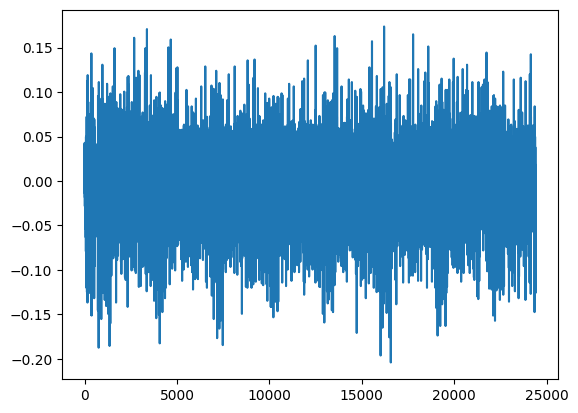

In [11]:
plt.plot(t[0])

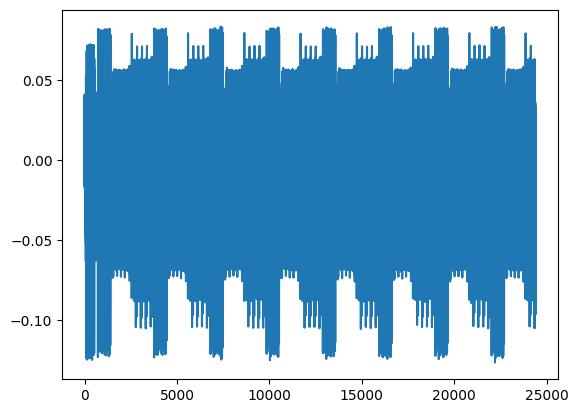

In [12]:
plt.plot(np.mean(t, axis=0))

## 印出明文、密文、金鑰

In [13]:
print("Plaintext: ")
print("Size=", p.shape, sep="")
print(p)
print("")

print("Cyphertext: ")
print("Size=", c.shape, sep="")
print(c)
print("")

print("Key: ")
print("Size=", k.shape, sep="")
print(k)

Plaintext: 
Size=(2000, 16)
[[240 195  62 ...  14 147 203]
 [112  58 238 ...   6 189 221]
 [246  12   3 ...  23  39  28]
 ...
 [136 146  39 ...  32 195  65]
 [234 143 146 ...   5  24 217]
 [255 131  80 ... 219  62 150]]

Cyphertext: 
Size=(2000, 16)
[[190 100 141 ...  22 211 141]
 [133 104 221 ...  34  74 205]
 [209 157  36 ... 240  65  57]
 ...
 [213 233  81 ...   0  51   9]
 [235 110 105 ... 207 145  86]
 [ 31 200  29 ...  68  80 241]]

Key: 
Size=(2000, 16)
[[ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]
 ...
 [ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]
 [ 43 126  21 ... 207  79  60]]


## 明文 xor 金鑰

In [14]:
x = p ^ k
print("明文 xor 金鑰: ")
print("Size=", x.shape, sep="")
print(x)

明文 xor 金鑰: 
Size=(2000, 16)
[[219 189  43 ... 193 220 247]
 [ 91  68 251 ... 201 242 225]
 [221 114  22 ... 216 104  32]
 ...
 [163 236  50 ... 239 140 125]
 [193 241 135 ... 202  87 229]
 [212 253  69 ...  20 113 170]]


## Sbox轉換

In [15]:
y = AES_Sbox[x]
print("sBox轉換後: ")
print("Size=", y.shape, sep="")
print(y)

sBox轉換後: 
Size=(2000, 16)
[[185 122 241 ... 120 134 104]
 [ 57  27  15 ... 221 137 248]
 [193  64  71 ...  97  69 183]
 ...
 [ 10 206  35 ... 223 100 255]
 [120 161  23 ... 116  91 217]
 [ 72  84 110 ... 250 163 172]]


## 做 Hamming Weight

In [16]:
h = hw_list[y]
print("Hamming Weight轉換後: ")
print("Size=", h.shape, sep="")
print(h)

Hamming Weight轉換後: 
Size=(2000, 16)
[[5 5 5 ... 4 3 3]
 [4 4 4 ... 6 3 5]
 [3 1 4 ... 3 3 6]
 ...
 [2 5 3 ... 7 3 8]
 [4 3 4 ... 4 5 5]
 [2 3 5 ... 6 4 4]]


## 計算分群後平均的變異數(分母)、分群後變異數的平均(分母)

In [17]:
print("設定參數")
var = np.zeros((16, trace_length))    # 存16bytes分群後平均的變異數
avg = np.zeros((16, trace_length))    # 存16bytes分群後變異數的平均
SNR = np.zeros((16, trace_length))    # 存16bytes的SNR
avg_diff_HW = np.zeros((16, 9, trace_length)) # 存16bytes的九群的平均
var_diff_HW = np.zeros((16, 9, trace_length)) # 存16bytes的九群的變異數
count = np.zeros((16, 9), dtype=int)                    # 存 HW=0 ~ HW=8各有多少個

print("計算開始")
for b in range(16):                          # 16 bytes做16次
    t_sum = np.zeros((9, trace_length))      # 分成9群
    t2_sum = np.zeros((9, trace_length))
    avg_t = np.zeros((9, trace_length))
    avg2_t = np.zeros((9, trace_length))
    var_t = np.zeros((9, trace_length))
    
    for j in range(trace_num):               # 對每一行(每一byte)的不同 HW 做分群
        target = h[j, b]                     # 取得第j行(每一byte)所有HW，target會得到介於0到8的數值
        t_sum[target] += t[j]                # 將第j條波形的5000個樣本點加總到對應的 target index 那格中
        t2_sum[target] += t[j] ** 2
        count[b][target] += 1                # 九格分別代表 HW 0~8 共有多少條trace的
        
    prob = count[b] / trace_num              # 每一Byte"實際上"出現的機率
    
    for j in range(9):
        avg_t[j] = t_sum[j] / count[b][j]                     # 計算分群的平均
        var_t[j] = t2_sum[j] / count[b][j] - avg_t[j] ** 2    # 計算分群的變異數
    
    # 下面計算分群後平均的變異數; 平方的平均 - 平均的平方
    var[b] = sum((avg_t ** 2) * prob.reshape(9, 1)) - sum(avg_t * prob.reshape(9, 1)) ** 2
    avg[b] = sum(var_t * prob.reshape(9, 1)) # 計算分群變異數的平均
    
    avg_diff_HW[b] = avg_t
    var_diff_HW[b] = var_t

print("計算結束")

設定參數
計算開始
計算結束


## 印出 16 Bytes中 HW=0 ~ HW=8 分別有幾條Traces

In [18]:
for b in range(16):
    print("第{}Byte".format(b))
    for j in range(9):
        print("HW={}, 共有{:5d}條Traces.".format(j, count[b][j]))

第0Byte
HW=0, 共有    4條Traces.
HW=1, 共有   67條Traces.
HW=2, 共有  220條Traces.
HW=3, 共有  434條Traces.
HW=4, 共有  559條Traces.
HW=5, 共有  426條Traces.
HW=6, 共有  232條Traces.
HW=7, 共有   55條Traces.
HW=8, 共有    3條Traces.
第1Byte
HW=0, 共有    9條Traces.
HW=1, 共有   55條Traces.
HW=2, 共有  223條Traces.
HW=3, 共有  460條Traces.
HW=4, 共有  551條Traces.
HW=5, 共有  431條Traces.
HW=6, 共有  201條Traces.
HW=7, 共有   62條Traces.
HW=8, 共有    8條Traces.
第2Byte
HW=0, 共有    2條Traces.
HW=1, 共有   74條Traces.
HW=2, 共有  200條Traces.
HW=3, 共有  468條Traces.
HW=4, 共有  534條Traces.
HW=5, 共有  438條Traces.
HW=6, 共有  221條Traces.
HW=7, 共有   58條Traces.
HW=8, 共有    5條Traces.
第3Byte
HW=0, 共有    7條Traces.
HW=1, 共有   68條Traces.
HW=2, 共有  181條Traces.
HW=3, 共有  465條Traces.
HW=4, 共有  539條Traces.
HW=5, 共有  459條Traces.
HW=6, 共有  215條Traces.
HW=7, 共有   58條Traces.
HW=8, 共有    8條Traces.
第4Byte
HW=0, 共有    7條Traces.
HW=1, 共有   63條Traces.
HW=2, 共有  225條Traces.
HW=3, 共有  419條Traces.
HW=4, 共有  549條Traces.
HW=5, 共有  448條Traces.
HW=6, 共有  218條Traces.
HW=7, 共有   66條Trace

## 印出分群後平均的變異數

In [19]:
print("分群後平均的變異數:")
print("Size=", var.shape, sep="")
for j in range(16):
    print("第 {:2} byte ".format(j), end="")
    print(var[j])

分群後平均的變異數:
Size=(16, 24400)
第  0 byte [2.61215560e-07 1.72504689e-06 1.15493509e-06 ... 3.32211494e-06
 6.48428597e-07 2.55900799e-07]
第  1 byte [8.21170706e-07 1.68928429e-06 2.07595548e-06 ... 7.18292302e-06
 1.30725100e-06 7.70825740e-07]
第  2 byte [1.40187284e-06 2.74551781e-06 1.23542879e-06 ... 1.27583780e-06
 3.54005749e-07 1.84843465e-07]
第  3 byte [1.19015880e-06 1.17543829e-06 5.72357770e-07 ... 3.20365493e-06
 1.23509881e-06 8.10217137e-08]
第  4 byte [1.90003774e-07 1.70611486e-06 9.95868076e-07 ... 1.20755446e-06
 1.34188657e-06 2.55223299e-07]
第  5 byte [6.62031014e-07 2.37788265e-06 5.27484201e-07 ... 1.36986691e-06
 1.00107510e-06 2.01723570e-07]
第  6 byte [2.20459724e-06 4.15645301e-07 2.21704998e-06 ... 3.82090890e-06
 6.60803065e-07 2.24420312e-07]
第  7 byte [3.25121219e-07 1.74309866e-06 2.54292946e-06 ... 4.19740748e-06
 1.51108592e-06 1.71290404e-07]
第  8 byte [9.34436227e-07 1.29074466e-06 2.49985759e-06 ... 3.71155919e-06
 1.13865373e-06 3.33577674e-07]
第  9 byte

## 印出分群後變異數的平均

In [20]:
print("分群後變異數的平均:")
print("Size=", avg.shape, sep="")
for j in range(16):
    print("第 {:2} byte ".format(j), end="")
    print(avg[j])

分群後變異數的平均:
Size=(16, 24400)
第  0 byte [2.46261573e-04 3.34048573e-04 3.16820062e-04 ... 7.16579844e-04
 3.38144750e-04 8.71481891e-05]
第  1 byte [2.45701618e-04 3.34084336e-04 3.15899042e-04 ... 7.12719035e-04
 3.37485928e-04 8.66332642e-05]
第  2 byte [2.45120916e-04 3.33028103e-04 3.16739569e-04 ... 7.18626121e-04
 3.38439173e-04 8.72192465e-05]
第  3 byte [2.45332630e-04 3.34598182e-04 3.17402640e-04 ... 7.16698304e-04
 3.37558080e-04 8.73230682e-05]
第  4 byte [2.46332785e-04 3.34067506e-04 3.16979129e-04 ... 7.18694404e-04
 3.37451292e-04 8.71488666e-05]
第  5 byte [2.45860758e-04 3.33395738e-04 3.17447513e-04 ... 7.18532092e-04
 3.37792103e-04 8.72023664e-05]
第  6 byte [2.44318192e-04 3.35357975e-04 3.15757948e-04 ... 7.16081050e-04
 3.38132375e-04 8.71796696e-05]
第  7 byte [2.46197668e-04 3.34030522e-04 3.15432068e-04 ... 7.15704551e-04
 3.37282093e-04 8.72327995e-05]
第  8 byte [2.45588353e-04 3.34482876e-04 3.15475140e-04 ... 7.16190399e-04
 3.37654525e-04 8.70705123e-05]
第  9 byte

## 印出 16 Bytes的SNR數值

In [21]:
SNR = var / avg
print("SNR:")
print("Size=", SNR.shape, sep="")
for j in range(16):
    print("第 {:2} byte ".format(j), end="")
    print(SNR[j])

SNR:
Size=(16, 24400)
第  0 byte [0.00106072 0.00516406 0.0036454  ... 0.00463607 0.00191761 0.00293639]
第  1 byte [0.00334215 0.00505646 0.00657158 ... 0.0100782  0.0038735  0.00889757]
第  2 byte [0.00571911 0.0082441  0.00390046 ... 0.00177538 0.001046   0.0021193 ]
第  3 byte [0.0048512  0.00351298 0.00180325 ... 0.00447002 0.00365892 0.00092784]
第  4 byte [0.00077133 0.0051071  0.00314175 ... 0.00168021 0.00397653 0.00292859]
第  5 byte [0.00269271 0.00713231 0.00166164 ... 0.00190648 0.00296358 0.00231328]
第  6 byte [0.00902347 0.00123941 0.00702136 ... 0.00533586 0.00195427 0.00257423]
第  7 byte [0.00132057 0.00521838 0.00806173 ... 0.00586472 0.00448018 0.0019636 ]
第  8 byte [0.00380489 0.00385893 0.0079241  ... 0.00518236 0.00337224 0.00383112]
第  9 byte [0.00520888 0.00159307 0.00467889 ... 0.00486392 0.00495929 0.00487143]
第 10 byte [0.00236497 0.00406077 0.00220446 ... 0.00337573 0.00228213 0.00228759]
第 11 byte [0.00088025 0.00248916 0.00339022 ... 0.00891345 0.01258975 0.0035

## 畫出 16 Bytes的SNR

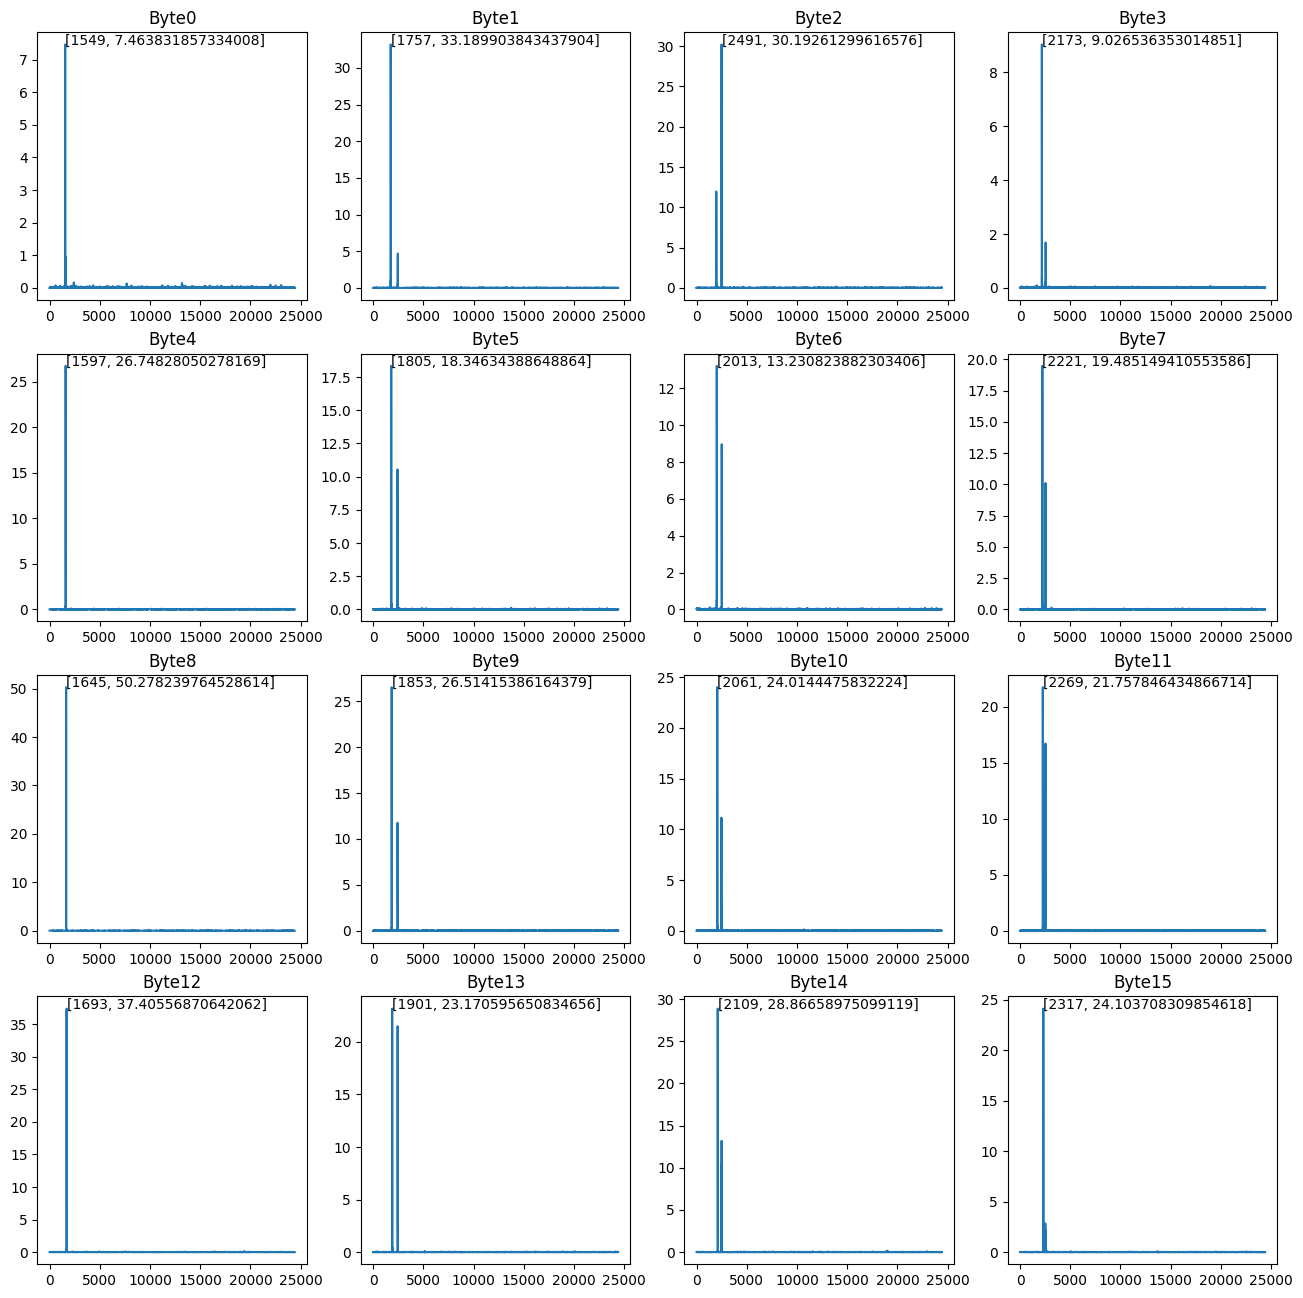

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))                   # 設定排版

for b in range(16):
    value = max(SNR[b])                                            # 存每一byte中最大的SNR值
    index = np.argmax(SNR[b])                                      # 存每一byte中最大的SNR值所在位置
    axes[b // 4, b % 4].text(index, value, '[{}, {}]'.format(index, value))
    axes[b // 4, b % 4].plot(SNR[b])
    axes[b // 4, b % 4].set_title("Byte{}".format(b))

## 只畫出 Byte0 的 SNR

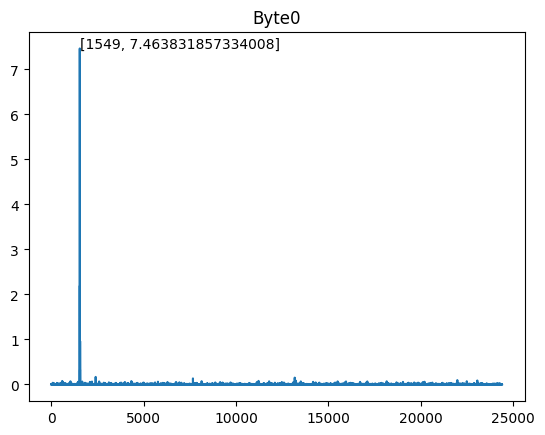

In [23]:
b = 0
value = max(SNR[b])
index = np.argmax(SNR[b])
plt.text(index, value, '[{}, {}]'.format(index, value))
plt.title("Byte{}".format(b))    
plt.plot(SNR[b, :])

## 畫出 16 Bytes的九群的平均波形

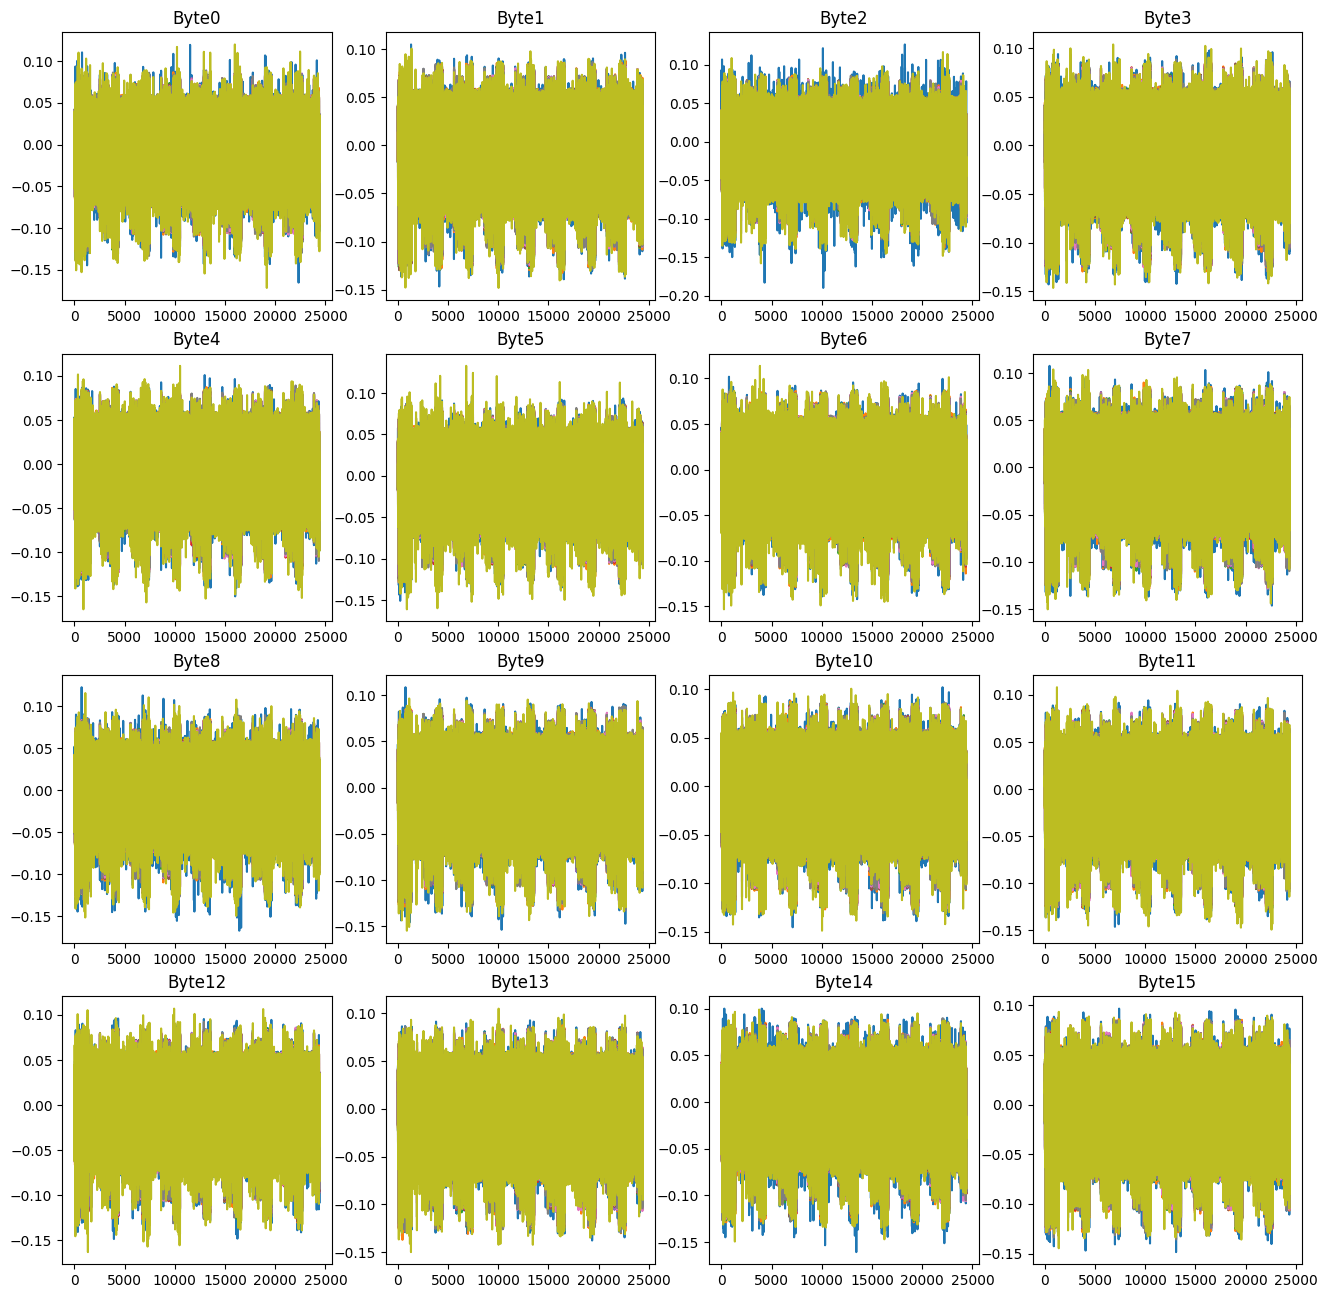

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))                   # 設定排版

for b in range(16):
    index = np.argmax(SNR[b])                                      # 存每一byte中最大的SNR值所在位置
    axes[b // 4, b % 4].plot(avg_diff_HW[b, :9, :].T)
    axes[b // 4, b % 4].set_title("Byte{}".format(b))

## 只畫出 Byte0 的九群平均波形

Text(0.5, 1.0, 'Byte0')

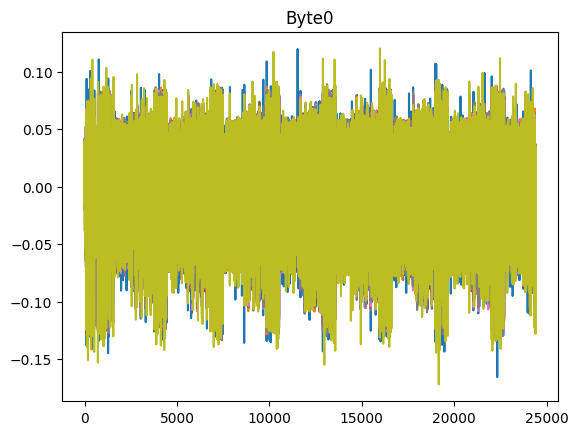

In [25]:
b = 0
index = np.argmax(SNR[b])                                      # 存每一byte中最大的SNR值所在位置
plt.plot(avg_diff_HW[b, :9, :].T)
plt.title("Byte{}".format(b))

## 畫出 16 Bytes的九群的平均波形(Zoom in)

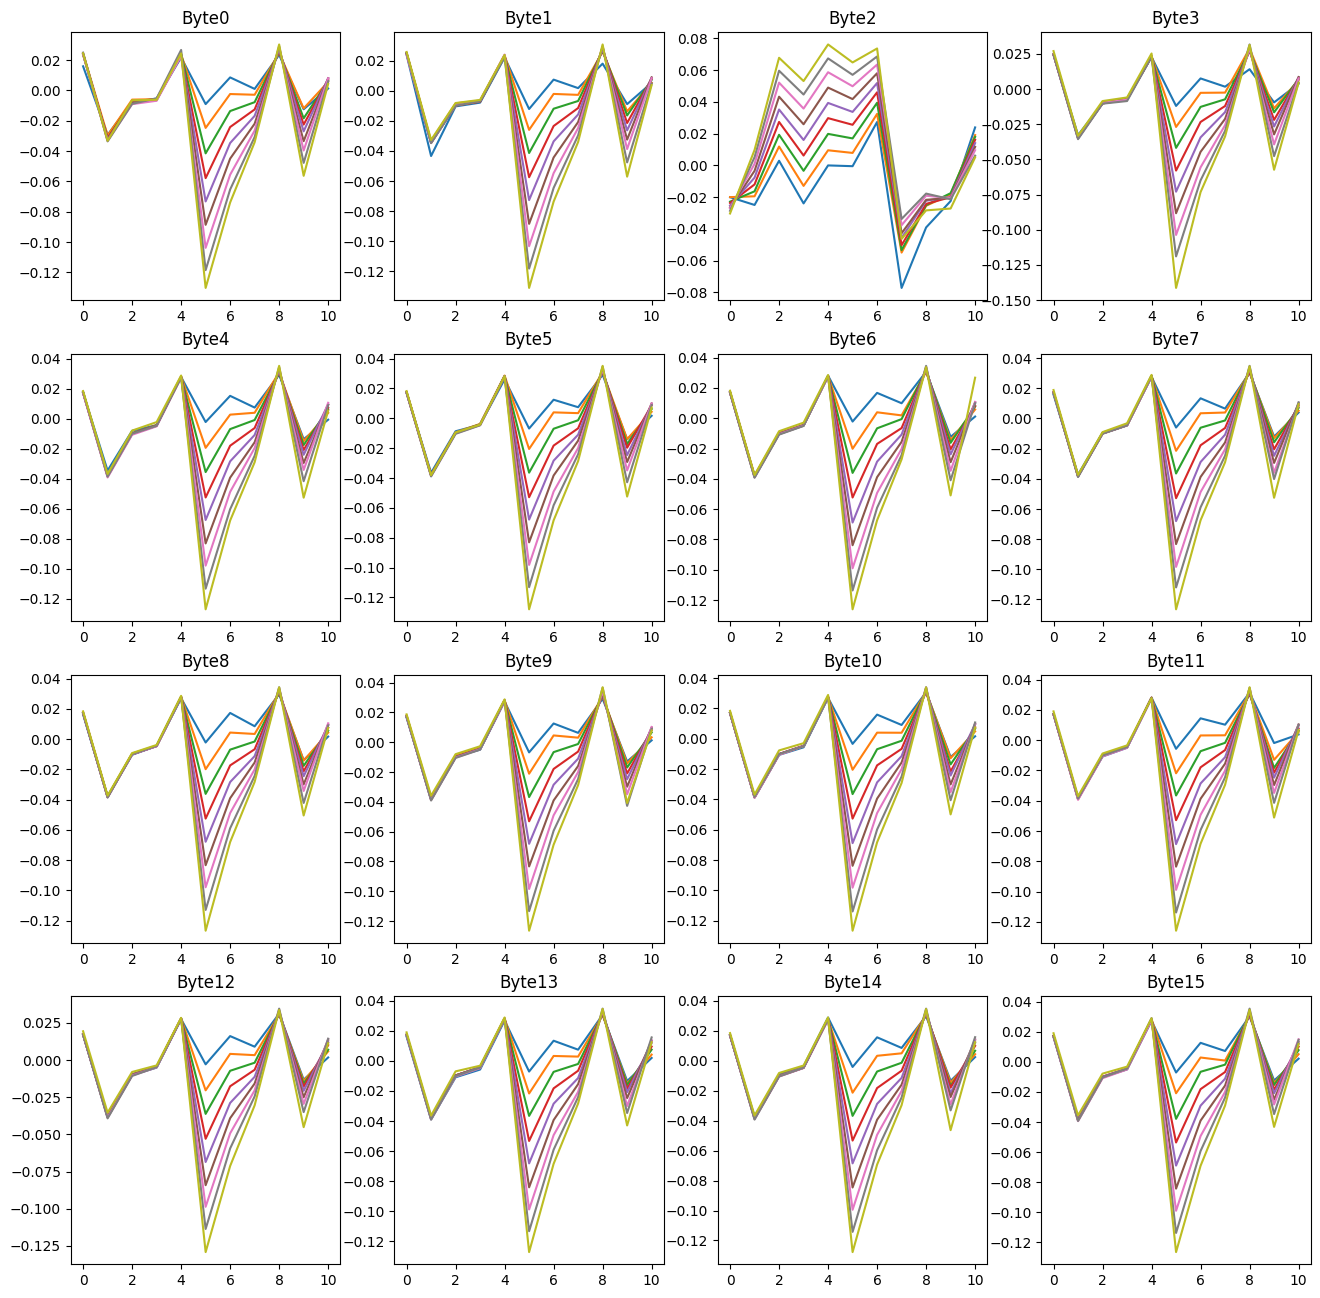

In [26]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))                   # 設定排版

for b in range(16):
    index = np.argmax(SNR[b])                                      # 存每一byte中最大的SNR值所在位置
    axes[b // 4, b % 4].plot(avg_diff_HW[b, :9, index-5:index+6].T)
    axes[b // 4, b % 4].set_title("Byte{}".format(b))

## 畫出 Byte 0 的九群的平均波形(Zoom in)

1549


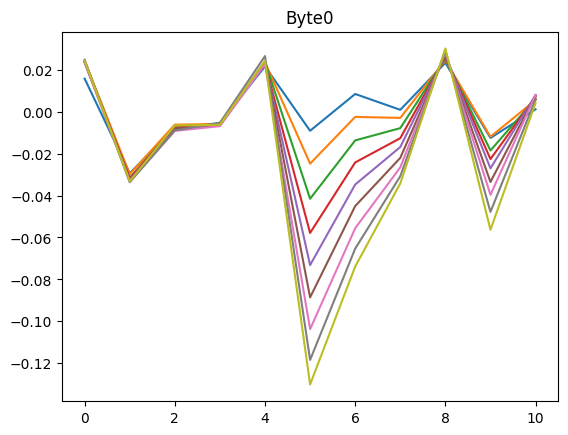

In [27]:
b = 0
index = np.argmax(SNR[b])
print(index)
plt.title("Byte{}".format(b))
plt.plot(avg_diff_HW[b, :9, index-5:index+6].T)

## 畫出 16 Bytes的九群的變異數波形

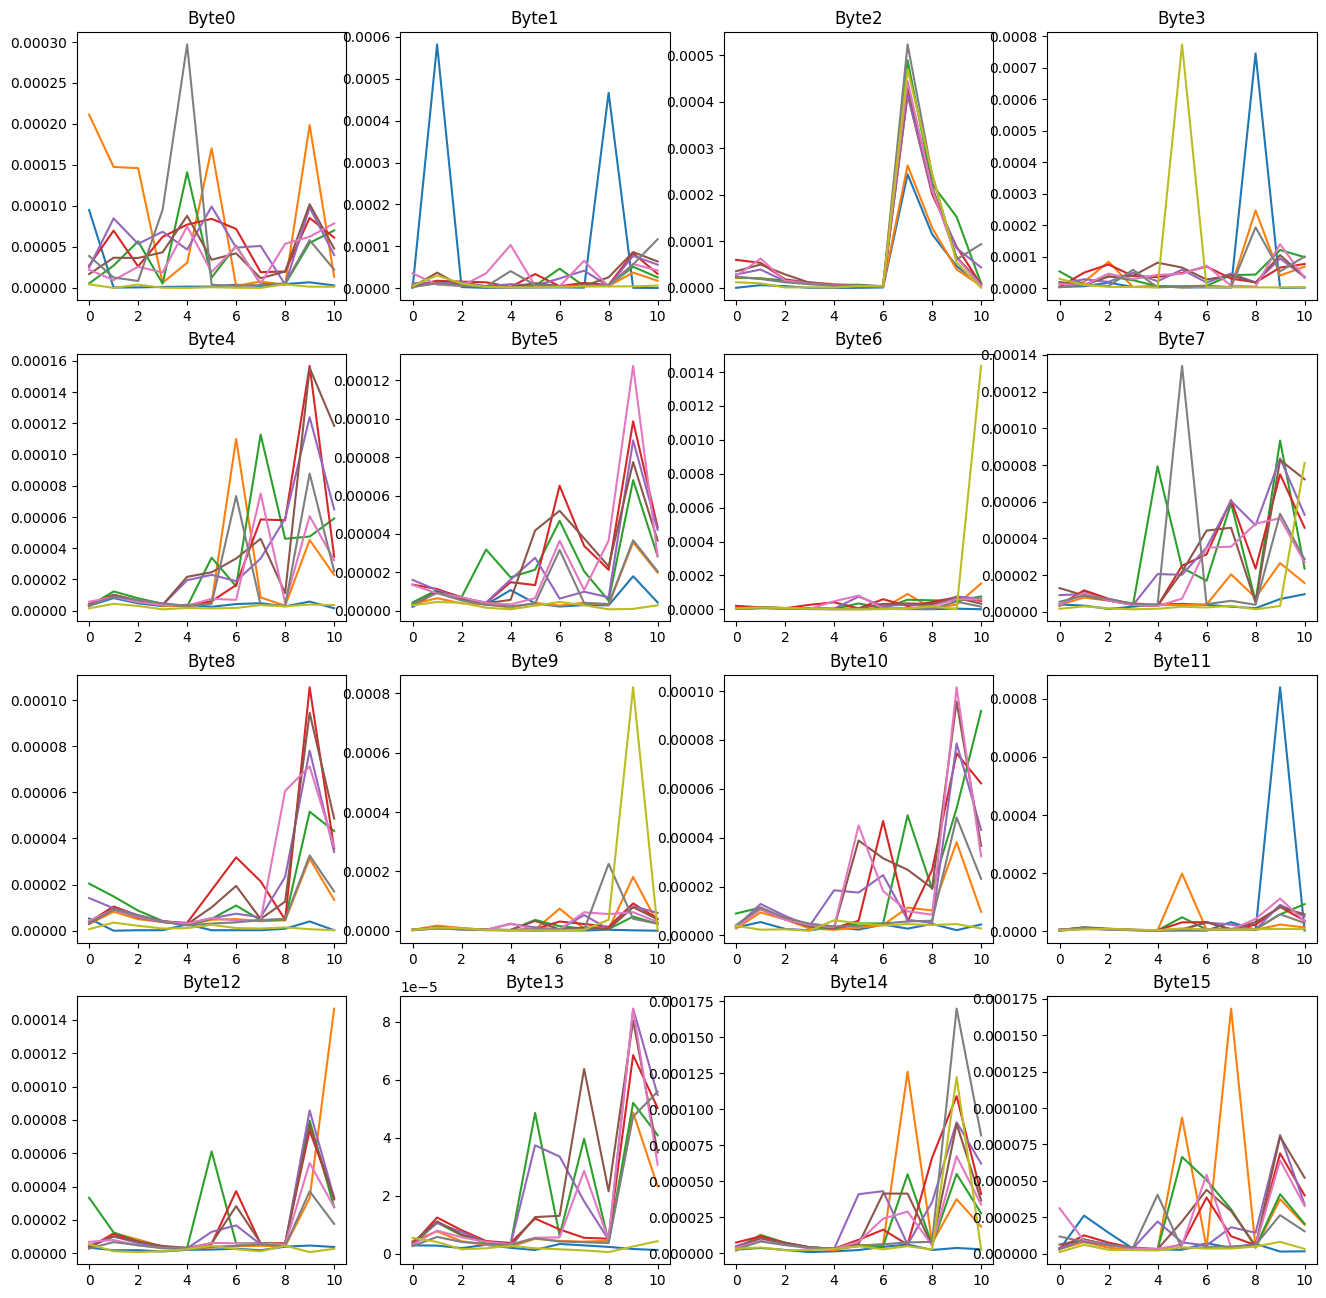

In [28]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))                   # 設定排版

for b in range(16):
    index = np.argmax(SNR[b])                                      # 存每一byte中最大的SNR值所在位置
    axes[b // 4, b % 4].set_title("Byte{}".format(b))
    axes[b // 4, b % 4].plot(var_diff_HW[b, :9, index-5:index+6].T)